# Analysis of railway user traffic over time

For this hypothetical company, they would like to forecast the usage of a railway system called JetTrain.
Data set can be found here:
https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/#ProblemStatement

In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from statsmodels.tsa.stattools import adfuller
# %matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 20

This railway system runs trains once an hour. We have roughly eighteen months of data with user traffic to analyze and seven months of data with no user traffic to predict. 

Things to consider:
- data is strictly positive
- noise in usage likely scales with increased usage
- trains run once an hour, every hour

In [2]:
# Create data frame from test data set in csv file
columns = ['Datetime', 'Count']
usage_data = pd.read_csv("/home/bacon/code/datasets/train_user_traffic_jetrail.csv", delimiter = ",", usecols=columns)

In [3]:
# A look at how the data is stored
# Still having trouble getting pandas to correctly parse "Datetime" as a datetime object...
print(usage_data[:3])

           Datetime  Count
0  25-08-2012 00:00      8
1  25-08-2012 01:00      2
2  25-08-2012 02:00      6


It definitely looks like we have some sort of upward trend with a lot of noise. As we noted, the noise seems to grow as the mean of usage grows. It makes sense that something that would make people more likely to use this train at a given time (positive news report of the service, local sports event, etc) would scale with how likely people are to use this particular train in general. I.e. if only a few people prefer this train service over another, we won't see huge increases or decreases from a hidden event. 

With an augmented Dicky Fuller test, courtesy of statsmodels, we can back up our claim that this is a non stationary time series. (The more negative the test statistic of this hypothesis test, the more certain we can be that this is a time series with a trend.)

This is our test statistic for a stationary series:  -4.4565605368568075


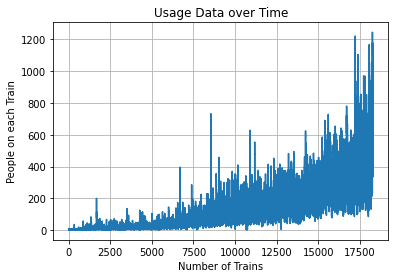

In [4]:
# Stationary hypothesis test
stationarity_test = adfuller(usage_data['Count'])
print("This is our test statistic for a stationary series: ", stationarity_test[0])

# First look at a plot of our time series
plt.plot(usage_data.index, usage_data['Count'])
plt.xlabel("Number of Trains")
plt.ylabel("People on each Train")
plt.title("Usage Data over Time")
plt.show()

Interesting that the all time low of users is two. We never have no one on the train! Seems odd for a train company that runs even at 4am.

In [5]:
minimum = usage_data['Count'].min()
print(minimum)

2


If we want to analyze the frequency content of the data, it's important to note that a fourier transform would be inappropriate. A fourier transform assumes, fundamentally, that the signal is periodic, whereas our data is a realization of a random process. Instead, we consider the power spectral density of the time series. 

We're going to assume that the high frequency content of the data is mostly noise and try to filter that out. Hopefully, we're left with the real trend underneath. 

In [6]:
fs = 1.0/3600
filt = scipy.signal.butter(8, 0.0005/3600, btype="low", output="sos", fs=fs)
filtered = scipy.signal.sosfilt(filt, usage_data['Count'])

freqs, psd = scipy.signal.welch(usage_data['Count'], fs=fs, nperseg=24*15)
freqs_filtered, psd_filtered = scipy.signal.welch(filtered, fs=fs, nperseg=24*15)

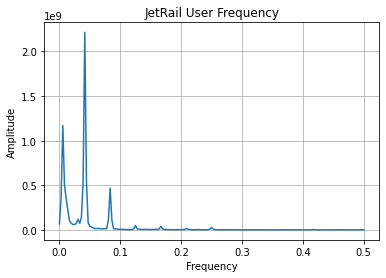

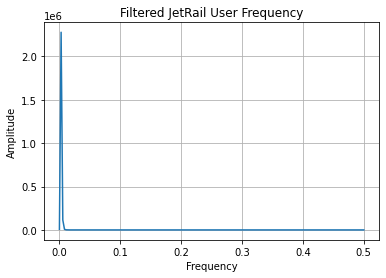

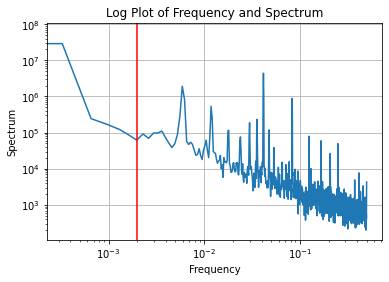

In [19]:
plt.plot(freqs*3600, psd)
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("JetRail User Frequency")
plt.show()

plt.plot(freqs_filtered*3600, psd_filtered)
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Filtered JetRail User Frequency")
plt.show()

span = usage_data['Count'].shape[0] // 6
frequency, spectrum = scipy.signal.welch(usage_data['Count'], fs=1.0, nperseg=span, detrend=False)
plt.figure()
plt.loglog(frequency, spectrum)
plt.ylabel("Spectrum");
plt.xlabel("Frequency");
plt.title("Log Plot of Frequency and Spectrum")
# Visually identify a good cutoff to seperate the low frequency trend
cutoff = 2e-3
plt.axvline(cutoff, color='r');

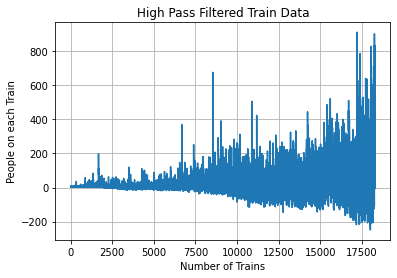

In [8]:
high_pass_filtered = usage_data['Count'].values - filtered

plt.xlabel("Number of Trains")
plt.ylabel("People on each Train")
plt.title("High Pass Filtered Train Data")
plt.plot(usage_data.index, high_pass_filtered)
plt.show()

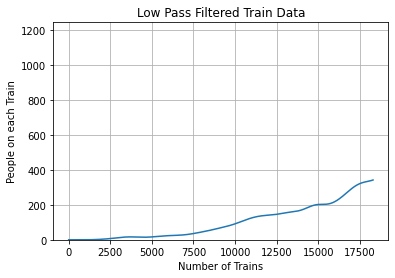

In [9]:
plt.xlabel("Number of Trains")
plt.ylabel("People on each Train")
plt.title("Low Pass Filtered Train Data")
plt.plot(usage_data.index, filtered)
plt.ylim([0, usage_data['Count'].max()])
plt.show()

Examining what the residuals and fit would look like for a naive polynomial model to our filtered signal. Definitely looks like we have information still in those residuals, but our filtered "signal" is kind of arbitrary. I could artificially make the threshold on the low pass filter lower (so more high frequency content is gone) and make the residuals look perfect. Either way, this model is only to explore the data set.

In [11]:
x_data = usage_data.index.values
(poly_coeff, residuals, _, _, _) = np.polyfit(x_data, filtered, deg=3, full=True)
print("Naive Polynomial Fit : {}*x^3 + {}*x^2 + {}*x + {}".format(poly_coeff[0], poly_coeff[1], poly_coeff[2], poly_coeff[3]))
model = np.polyval(poly_coeff, x_data)

Naive Polynomial Fit : 2.3658252079412684e-11*x^3 + 5.206608759628415e-07*x^2 + 0.0009950585732582831*x + -1.031095209489827


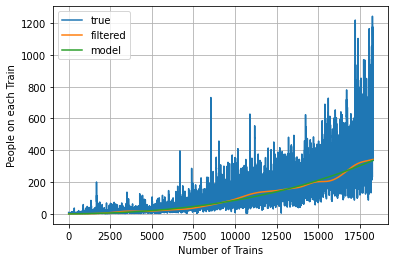

In [12]:
plt.plot(x_data, usage_data['Count'], label = "true")
plt.plot(x_data, filtered, label = "filtered")
plt.plot(x_data, model, label = "model")
plt.xlabel("Number of Trains")
plt.ylabel("People on each Train")
plt.legend()
plt.show()

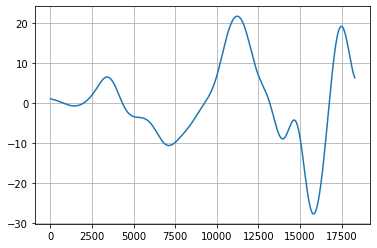

In [13]:
plt.plot(x_data, filtered - model, label='residuals')
plt.show()
# TODO acorr_ljungbox(filtered - model, model_df=3, return_df=True)

Let's see what values are most common among the series. It's clear that the data spends most of its time under fifty passengers, but if our data set was much larger, we'd probably see the distribution shift. 

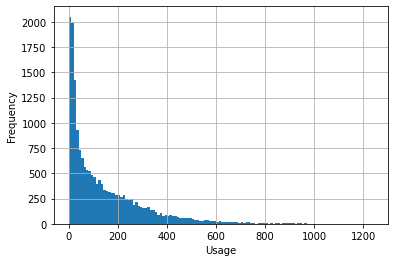

In [18]:
bin_size = 10
plt.figure()
plt.hist(usage_data['Count'], bins=np.arange(0, usage_data['Count'].max(), bin_size, dtype=int))
plt.ylabel("Frequency")
plt.xlabel("Usage")
plt.show()

What about over slices of time? As we thought, we see both the average number of people on the train and the variance in the amount increase over time.

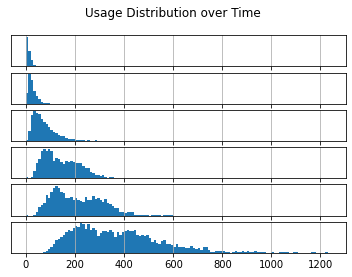

In [15]:
periods = 6
span = usage_data.shape[0] // periods
figure, axes = plt.subplots(periods, 1, sharex=True)
figure.suptitle("Usage Distribution over Time")
for i, axis in enumerate(axes):
    window = usage_data['Count'][i*span:(i+1)*span]
    axis.hist(window, bins=np.arange(0, np.max(window), bin_size, dtype=int))
    axis.set_yticks([])

We definitely data that looks, feels, and smells like a possion distribution whose mean varies with time.
What would that look like?

This might work, we can see how this looks more like shape of the data than our polynomial fit, but clearly the variance is way too low. Apparently this is a very common problem! Overdispersion. We could inject more variance into the model a lot of different ways - using a negative binomial distribution, quasi poisson distribution, etc. 

But what is that really telling us?

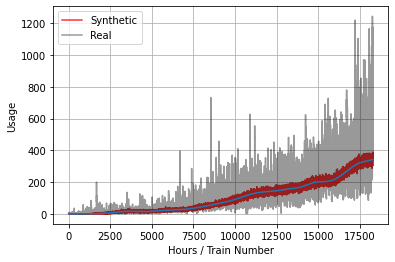

In [17]:
cutoff = 2e-3
lowpass = scipy.signal.butter(20, cutoff, "low", False, "sos", 1)
trend = scipy.signal.sosfilt(lowpass, usage_data['Count'])
hours = usage_data.index
sample = np.array([np.random.poisson(m) for m in filtered])

plt.figure()
plt.plot(hours, sample, color='r', alpha=0.8, label="Synthetic")
plt.plot(hours, usage_data['Count'], color='k', alpha=0.4, label="Real")
plt.plot(hours, filtered)
plt.legend()
plt.ylabel("Usage")
plt.xlabel("Hours / Train Number")
plt.show()

Viewing this data from a statistical lens, assuming that the series is a function of time (our filtered trend/signal) plus some model of the noise means that our count of train passengers at each time step is independent from the amount of passengers we have at every other time step. We're saying that our system only depends on time and no other variables - previous number of passengers, good news coverage, etc. I'd like to have a model that, instead, allows for conditional dependence on other time steps. It will better reflect the dynamics of this data set and hopefully also result in a better model.

For our time varying poisson approach, we're still assuming that each train's passenger count is independent of everything else except time, because we're saying that the poisson distribution at each time step depends on our filtered signal. Which is just a function of time! We've lost structure here. 

Maybe a more principled approach would be to replace our filtered signal dependence with a Hidden Markov Model (HMM).

Thoughts:
- ARMA has a corresponding HMM, so choosing to use ARMA, while it does let our model depend on the previous states, would be more limiting than choosing an HMM. We'd also have to deal with the unit root-ness of the problem, since we have an upward trend, which vanilla ARMA is not equipped to handle. Of course, there is great literature on estimating the amount of differencing necessary to get a stationary time series.
    - Also, ARMA is inherently aphysical for this problem. We're going to get float predictions from it, which doesn't make sense for count data. We could do something arbitrary, like cast the prediction to an int, but that's ... arbitrary? There's probably a better solution.
- If we say that our hidden state is $x_i$ at a given time, how should we evolve $x$? We have to choose a distribution/process model that respects our data (positive integers)
    - Or, we could say that our measurements of the hidden state, let's call those y, is the one that goes from depending on a real valued random variable x to our $ \mathbb{N}$ domain of our time series. Note, our data is a realization of y, so we have a sample of $P(y|x)$. Our last poisson model was $P(y_i|x_i) = poisson(x_i)$, and $x_i$ was $filtered$_$signal[i]$.
- We could force x to vary more (to compensate for the overdispersion) by drawing $x$ from a gaussian centered at our previous value of the filtered signal, instead of picking $x$ to just deterministically be the value of our filtered signal at that time. 

    - $ x \sim \mathcal{N}(signal[i], \sigma) $

- That wouldn't be quite the right idea, because the gaussian allows us to get negative values for $x$. We could chose the probability distribution of $x$ to be Rayleigh or another positive only distribution. Need to think on this more. Currently leaning towards figuring out how to model $x$ with an HMM instead.
- A different ARMA approach, found here https://www.sciencedirect.com/science/article/abs/pii/S0167947318300033, would be to model $x$ with ARMA! We escape all of the qualms I had in the first bullet point and still have conditional dependence in the model. To be explicit, our model would then look like $P(y_i|x_i) = poisson(x_i)$ and $x_i$ is some transformation of weighted sum (average) of past filtered signal values (and some other terms). Our process model then becomes $x_i = \exp(signal$ $model + noise)$, where noise is an arma model of $x_{i-1}$'s.

My next goal is to implement the model I last mentioned above - referred to as integer value autoregressive poission models. 
Some papers I'd like to keep track of:
- https://www.tandfonline.com/doi/abs/10.1080/02664763.2013.800034
- https://www.sciencedirect.com/science/article/abs/pii/S0167947318300033